# General Tests
There is no rhyme or reason to this file, besides helping me test the code. Its all nonessential

# Testing Predict Features

In [3]:
import test_manifold_algorithms as tma
#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="iris.csv", split = "even", percent_of_anchors= [0.2], verbose = 2)

/yunity/arusty/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-05-31 13:19:53.852301: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 13:19:53.856614: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 13:19:53.912386: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 13:19:55.807


 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

Spliting the data evenly
Split A features shape: (150, 2)
Split B Features shape (150, 2)
MDS initialized with 2 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [4]:
from DIG import DIG
import numpy as np
test = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2)

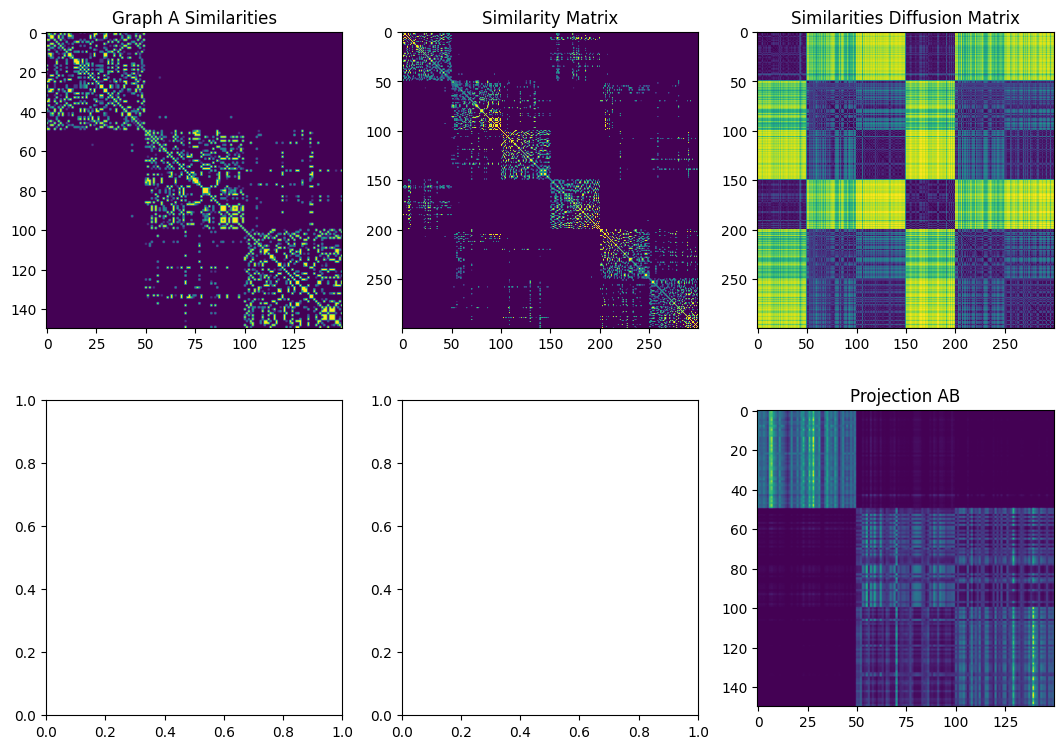

In [5]:
test.plot_graphs()

Model Stress: 37398.49890869508
Cross Embedding: 0.8333333333333334
FOSCTTM: 0.1468888888888889


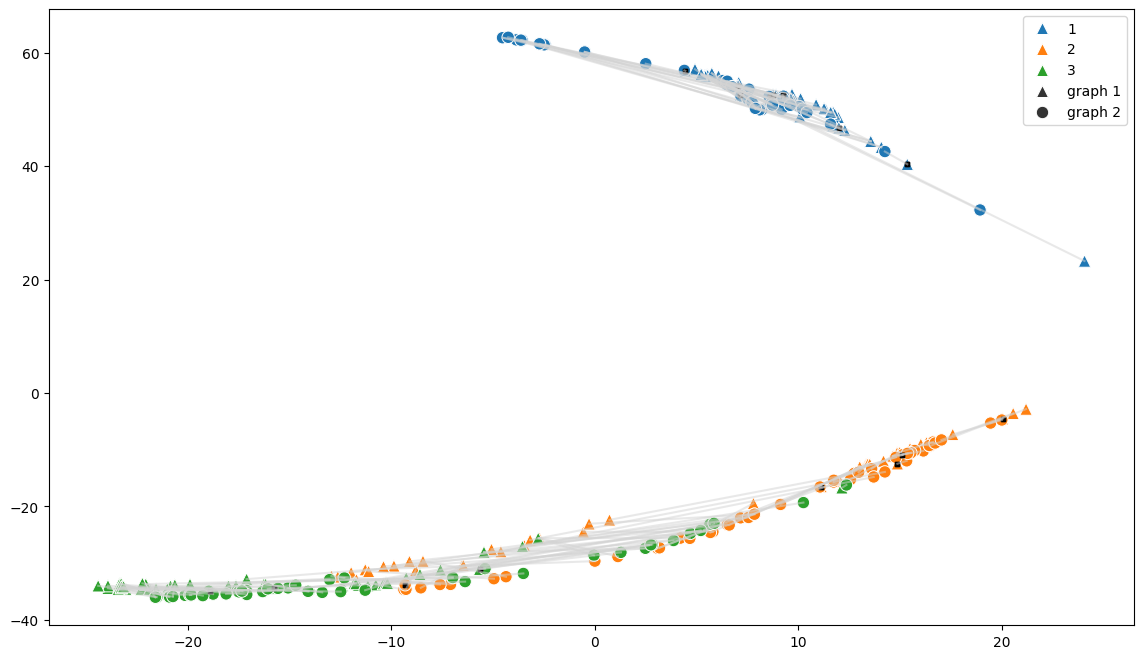

In [6]:
test.plot_emb(labels = dc.labels_doubled, block = test.sim_diffusion_matrix)

In [7]:
 def _find_possible_anchors2(self, anchor_limit = None, threshold = "auto", hold_out_anchors = []): #TODO: Make it so each point can only have one correspondence
        """A helper function that finds and returns a list of possible anchors after alignment.
        
        Parameters:
        :anchor_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :threshold: should be a float. If auto, the algorithm will determine it.
        The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
        They should be in the same format as the Known Anchors.
        
        returns possible anchors plus known anchors in a single list"""

        #Calculate the threshold
        if threshold == "auto":

            #Change Type so that we can convert to set 
            known_anchors_as_tuples = (tuple(arr) for arr in self.known_anchors)
            hold_out_anchors = [tuple(arr) for arr in hold_out_anchors]

            # Convert the list of tuples to a set for fast look ups
            set1 = set(known_anchors_as_tuples)

            #Remove indicies that are already known anchors
            hold_out_anchors[:] = [tup for tup in hold_out_anchors if tup not in set1]

            #Check to make sure we have Hold out anchors
            if len(hold_out_anchors) < 1:
                print("ERROR: No calculation preformed. Please provide hold_out_anchors and ensure they aren't known anchors already.")
                return []
            elif len(hold_out_anchors) < 2:
                #Since there is only one element, we set the threshold to be equal to its max plus a tiny bit
                threshold = self.sim_diffusion_matrix[hold_out_anchors[0][0], hold_out_anchors[0][1] + self.len_A]

            else:
                #Adjust the Hold_out_anchors to map in the merged graphs
                hold_out_anchors = np.array(hold_out_anchors)
                hold_out_anchors = np.vstack([hold_out_anchors.T[0], hold_out_anchors.T[1] + self.len_A]).T

                #Determine the average distance of the hold out anchors
                average_threshold = np.mean(self.sim_diffusion_matrix[hold_out_anchors[0], hold_out_anchors[1]]) #NOTE: we might have to adjust this value. 
                _65_percent_interval = np.std(self.sim_diffusion_matrix[hold_out_anchors[0], hold_out_anchors[1]])

                threshold = average_threshold + _65_percent_interval

        """This section actually finds and then curates potential anchors
        TODO: We sort it out so domain A can't have repeats, but it would be smarter to have the algorithm minimize the distance, 
        choosing the anchor matches that minimise the overall distance. """
        #Set the current known anchors to be above Threshold, so we dont find them again. Because its a one to one correspondance, we can block out the entire rows
        dist_matrix = self.sim_diffusion_matrix
        dist_matrix[self.known_anchors_adjusted[:, 0], :] = threshold + 1
        dist_matrix[:, self.known_anchors_adjusted[:, 1]] = threshold + 1

        #Get just the off diagonal part
        dist_matrix = dist_matrix[:self.len_A, self.len_A:]
 
        # Create a boolean mask where the distance is less than the threshold
        mask = dist_matrix < threshold

        # Use np.where to get the indices of the points that satisfy the condition
        possible_anchors = np.where(mask)

        #Check to see if any anchors have been found
        if len(possible_anchors) < 1:
            print("ERROR: No Possible anchors found. Try increasing the threshold")
            return []

        #Transpose it
        possible_anchors = np.array(possible_anchors).T
   
        #Check to see if any anchors have been found
        if len(possible_anchors) < 1:
            print("ERROR: No Possible anchors found. Try increasing the threshold")
            return []

        #Since the data is injective, remove all duplicate values, choosing the smallest TODO::: FIX THIS ___ ITS BROKEN
        unique_possible_anchors_A = np.unique(possible_anchors[:, 0])
        unique_possible_anchors_B = np.unique(possible_anchors[:, 1])
        lowest_match = np.argmin(dist_matrix[unique_possible_anchors_A][:, unique_possible_anchors_B], axis = 1) #Problem here
        possible_anchors = np.array([unique_possible_anchors_A, unique_possible_anchors_B[lowest_match]]).T

        #Apply the anchor Limit
        if type(anchor_limit) == int:
            # Extract the similarity values that are less than 0.1
            dist_values = self.sim_diffusion_matrix[:self.len_A, self.len_A:][mask]

            # Combine indices and values into a list of tuples
            indexed_values = list(zip(possible_anchors[:, 0], possible_anchors[:, 1], dist_values))

            # Sort the list of tuples by the similarity values (third element in the tuples)
            indexed_values = sorted(indexed_values, key=lambda x: x[2])

            # Print the indices and values of the first anchor Limit smallest similarities
            if self.verbose > 0:
                for i, (row, col, value) in enumerate(indexed_values[:anchor_limit]):
                    print(f"{i+1}: Index ({row}, {col}) - Similarity: {value}")
            
            # Select the first anchor_limit smallest values (or all if there are less than anchor_limit)
            possible_anchors = np.array(indexed_values)[:anchor_limit, 0:2].astype(int)

        #Add the anchors to the known anchors
        possible_anchors = np.concatenate((self.known_anchors, possible_anchors), axis = 0)

        return possible_anchors

In [11]:
from scipy.optimize import linear_sum_assignment
def _find_possible_anchors(self, anchor_limit = None, hold_out_anchors = []): 
    """A helper function that finds and returns a list of possible anchors after alignment.
        
    Parameters:
        :anchor_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :hold_out_anchors: These anchors are used as a test to predict what distance the anchors are 
            expected to have from one another. If none are give, it is assumed that anchors will be 
            have values closest to zero. 
        
    returns possible anchors plus known anchors in a single list"""

    #Set our array. This lets us modify it if we need to
    array = self.sim_diffusion_matrix[:test.len_A, test.len_A:]
    
    #Calculate the predicted anchor value
    if len(hold_out_anchors) > 0:

        #Change Type so that we can convert to set 
        known_anchors_as_tuples = (tuple(arr) for arr in self.known_anchors)
        hold_out_anchors = [tuple(arr) for arr in hold_out_anchors]

        # Convert the list of tuples to a set for fast look ups
        set1 = set(known_anchors_as_tuples)

        #Remove indicies that are already known anchors
        hold_out_anchors[:] = [tup for tup in hold_out_anchors if tup not in set1]

        #Check to make sure we have Hold out anchors
        if len(hold_out_anchors) < 1:
            print("ERROR: No calculation preformed. Please provide hold_out_anchors and ensure they aren't known anchors already.")
            return []
        elif len(hold_out_anchors) < 2:
            #Since there is only one element, we set the threshold to be equal to its max plus a tiny bit
            pred_anc_value = self.sim_diffusion_matrix[hold_out_anchors[0][0], hold_out_anchors[0][1] + self.len_A]

        else:
            #Adjust the Hold_out_anchors to map in the merged graphs
            hold_out_anchors = np.array(hold_out_anchors)
            hold_out_anchors = np.vstack([hold_out_anchors.T[0], hold_out_anchors.T[1] + self.len_A]).T

            #Determine the average distance of the hold out anchors
            pred_anc_value = np.mean(self.sim_diffusion_matrix[hold_out_anchors[0], hold_out_anchors[1]]) #NOTE: we might have to adjust this value. 
            _65_percent_interval = np.std(self.sim_diffusion_matrix[hold_out_anchors[0], hold_out_anchors[1]]) #If values are outside this range, maybe we through them out?

        #Adjust the array 
        array = abs(array - pred_anc_value)

    #Flatten array
    flat_array = array.flatten()

    #Get the sorted indices
    sorted_indices = np.argsort(flat_array)
    
    # Convert the sorted indices to coordinates
    coordinates = [np.unravel_index(index, array.shape) for index in sorted_indices]
    
    # Create a cost matrix using the top (num_pairs * num_pairs) smallest elements
    selected_coords = coordinates[:anchor_limit * anchor_limit]
    num_elements = len(selected_coords)
    
    # Construct the reduced cost matrix
    cost_matrix = np.full((num_elements, num_elements), np.inf)
    
    for i, (row_i, col_i) in enumerate(selected_coords):
        for j, (row_j, col_j) in enumerate(selected_coords):
            if row_i != row_j and col_i != col_j:
                cost_matrix[i, j] = array[row_j, col_j]
    
    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create a list to store results
    min_pairs = []

    #Keep track of used rows, counting the sets with anchors as used already
    used_rows = set(self.known_anchors[:, 0])
    used_cols = set(self.known_anchors[:, 1])
    
    #Repeat through the values
    for i in range(len(row_ind)):
        row, col = selected_coords[row_ind[i]]

        #Check to make sure we haven't used the row or column yet (this is becaue is anchor is assumed to have a 1 to 1 correspondence)
        if row not in used_rows and col not in used_cols:

            #Add the data
            min_pairs.append((row, col))
            used_rows.add(row)
            used_cols.add(col)

            #Break once we hit our limit
            if len(min_pairs) >= anchor_limit:
                break
    
    return min_pairs, array


In [12]:
dummy_array = [(27,27), (14, 14), (37, 37), (120, 120)]

In [13]:
pairs, array = _find_possible_anchors(test, anchor_limit = 4, hold_out_anchors=dummy_array)
# Print the pairs and their corresponding values
for i, (row, col) in enumerate(pairs):
    print(f"Pair {i+1}: ({row}, {col}) with value {array[row, col]}")

Pair 1: (109, 112) with value 0.005892754920442833
Pair 2: (18, 17) with value 0.010592495250872247
Pair 3: (103, 139) with value 0.011279658667004533
Pair 4: (127, 104) with value 0.012671866574414103


In [15]:
pairs, array = _find_possible_anchors(test, anchor_limit = 17)
# Print the pairs and their corresponding values
for i, (row, col) in enumerate(pairs):
    print(f"Pair {i+1}: ({row}, {col}) with value {array[row, col]}")

Pair 1: (70, 70) with value 0.0
Pair 2: (59, 59) with value 0.05439907443267807
Pair 3: (35, 35) with value 0.10107419027097703
Pair 4: (55, 55) with value 0.1113929976717847
Pair 5: (139, 139) with value 0.11590907042225682
Pair 6: (22, 22) with value 0.14411931069003453
Pair 7: (28, 28) with value 0.23083361126054244
Pair 8: (8, 8) with value 0.293328368263985
Pair 9: (108, 108) with value 0.2945606990055069
Pair 10: (129, 129) with value 0.3637985494007612
Pair 11: (7, 7) with value 0.5480150287675767
Pair 12: (62, 62) with value 0.736158074776617
Pair 13: (26, 26) with value 0.7649022089562136
Pair 14: (6, 6) with value 0.8462040554505956
Pair 15: (57, 57) with value 1.0456360974399912
Pair 16: (21, 23) with value 1.2137087675957225
Pair 17: (39, 49) with value 1.3964665595346188


In [16]:
test.known_anchors

array([[ 28,  28],
       [  6,   6],
       [ 70,  70],
       [ 62,  62],
       [ 57,  57],
       [ 35,  35],
       [ 26,  26],
       [139, 139],
       [ 22,  22],
       [108, 108],
       [  8,   8],
       [  7,   7],
       [ 23,  23],
       [ 55,  55],
       [ 59,  59],
       [129, 129]])